<a href="https://colab.research.google.com/github/AIO2026/conq0015_blog/blob/main/Time_series_vn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chuỗi thời gian: Đặc điểm dữ liệu và một số lưu ý khi phân tích**

Dữ liệu chuỗi thời gian ngày càng phổ biến trong nghiên cứu khoa học và các mô hình phân tích dữ liệu kinh doanh hiện đại, từ dự báo nhu cầu, doanh thu, dòng tiền đến giám sát rủi ro, hành vi người dùng và vận hành hệ thống. Tuy nhiên, điểm khác biệt cốt lõi của chuỗi thời gian là dữ liệu thường mang cấu trúc phụ thuộc theo thời gian, chịu chi phối bởi xu thế, mùa vụ và mức độ dừng/không dừng. Khi đưa các thuật toán AI/ML vào phân tích, nếu xem chuỗi thời gian như dữ liệu bảng thông thường và bỏ qua các đặc điểm này, mô hình có để đưa tới các kết luận sai lệch so với thực tế. Vì vậy, một quy trình phân tích đúng cần bắt đầu từ việc hiểu cấu trúc chuỗi, thực hiện biến đổi dữ liệu hợp lý, rồi mới lựa chọn mô hình và cách đánh giá phù hợp theo thời gian.

## **1. Khái niệm dữ liệu chuỗi thời gian**

Dữ liệu chuỗi thời gian là dữ liệu được thu thập từ cùng một đối tượng tại các thời điểm khác nhau. Khác với dữ liệu chéo, dữ liệu chuỗi thời gian đặc biệt quan tâm đến trật tự của các quan sát, bộ dữ liệu phải được sắp xếp theo thứ tự thời gian. Bảng 1.1. minh hoạ dữ liệu chuỗi thời gian là chỉ số VN-Index từ ngày 17/12/2025 đến 15/01/2026. Các số liệu không thể được sắp xếp theo thứ tự ngẫu nhiên, mà thay vào đó, dữ liệu phải được sắp xếp theo một thứ tự thời gian cụ thể (có thể từ xa đến gần, hoặc ngược lại).

In [258]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import json
from IPython.display import HTML, display
import uuid

# Set a default font to avoid warnings about missing fonts
plt.rcParams['font.family'] = 'DejaVu Sans'

def create_vnindex_data():
    try:
        df = pd.read_csv('VNIndexHistoricalData.csv')
        df['Date'] = pd.to_datetime(df['Date'])

        if df['Price'].dtype == 'object':
            df['VN-Index'] = df['Price'].astype(str).str.replace(',', '').astype(float)
        else:
            df['VN-Index'] = df['Price']

        df = df.sort_values('Date').reset_index(drop=True)

        start_date = '2025-12-17'
        end_date = '2026-01-15'
        mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
        df_filtered = df.loc[mask].copy()

        rl = [{
            'date': row['Date'].isoformat(),
            'dateStr': row['Date'].strftime('%d/%m'),
            'value': row['VN-Index']
        } for _, row in df_filtered.iterrows()]

        return rl

    except FileNotFoundError:
        print("⚠️ Lỗi: Không tìm thấy file 'VNIndexHistoricalData.csv'.")
        print("   -> Vui lòng upload file hoặc kiểm tra lại tên file.")
        return []
    except Exception as e:
        print(f"⚠️ Có lỗi khi xử lý dữ liệu trong create_vnindex_data: {e}")
        return []

vnindex_props = {
    "data": create_vnindex_data(),
}

In [259]:
def to_float(obj):
    if isinstance(obj, np.generic):
        return obj.item()
    return obj

props_json = json.dumps(vnindex_props, default=to_float)

div_id = f"react-root-{uuid.uuid4()}"

html = f"""
<div id="{div_id}" style="width:100%; max-width:900px; margin:auto;"></div>

<script type="module">
  import React, {{ useEffect, useRef }} from "https://esm.sh/react@18";
  import ReactDOM from "https://esm.sh/react-dom@18/client";
  import Chart from "https://esm.sh/chart.js@4.4.1/auto";

  const props = {props_json};

  function VNIndexAnalysis({{ data }}) {{
    const canvasRef = useRef(null);

    useEffect(() => {{
      if (!canvasRef.current) return;

      new Chart(canvasRef.current, {{
        type: "line",
        data: {{
          labels: data.map(d => d.dateStr),
          datasets: [{{
            label: "VN-Index",
            data: data.map(d => d.value),
            borderWidth: 2,
            tension: 0.3
          }}]
        }},
        options: {{
          responsive: true,
          plugins: {{
            legend: {{ display: true }}
          }}
        }}
      }});
    }}, []);

    return React.createElement(
      "div",
      {{
        style: {{
          background: "#fff",
          padding: "16px",
          borderRadius: "12px",
          boxShadow: "0 4px 20px rgba(0,0,0,0.08)"
        }}
      }},
      React.createElement("h3", {{ style: {{ textAlign: "center" }} }}, "📈 Bảng 1. Chỉ số VN-Index từ ngày 17/12/2025 đến 15/01/2026 (Nguồn: vietstock.vn)"),
      React.createElement("canvas", {{ ref: canvasRef, height: 300 }})
    );
  }}

  const root = ReactDOM.createRoot(document.getElementById("{div_id}"));
  root.render(React.createElement(VNIndexAnalysis, props));
</script>
"""

display(HTML(html))

Khi phân tích dữ liệu, người phân tích cần đặc biệt quan tâm đến dữ liệu chuỗi thời gian. Lý do là nhiều mô hình phân tích định lượng cơ bản thường yêu cầu giả thiết các quan sát là độc lập. Giả thiết này khó có thể đạt được trong dữ liệu chuỗi thời gian, do mỗi quan sát thường phụ thuộc vào các quan sát trước đó. Nói cách khác, trong dữ liệu chuỗi thời gian, thông tin ở quá khứ sẽ có ảnh hưởng đến tương lai. Ví dụ, chỉ số VN-Index ngày hôm qua cao, thì có rất nhiều khả năng chỉ số của ngày hôm nay sẽ cao. Chính do sự phụ thuộc mang tính chất thời gian, trong nhiều trường hợp, độ trễ của biến phụ thuộc được sử dụng như là một biến độc lập trong mô hình nghiên cứu.

## **2. Đặc điểm của dữ liệu chuỗi thời gian**

### **2.1. Tính xu thế**

Tính xu thế, còn được gọi là tính xu hướng, được hiểu là khuynh hướng thay đổi nhìn chung của dữ liệu chuỗi thời gian (tăng hoặc giảm). Hình 1 là minh hoạ về tính xu thế của một dữ liệu chuỗi thời gian, trong đó, các giá trị  nhận được tăng đều qua thời gian. Việc một biến có tính xu thế sẽ ảnh hưởng đến các suy luận từ kết quả phân tích định lượng, đặc biệt là vấn đề hồi quy giả mạo.

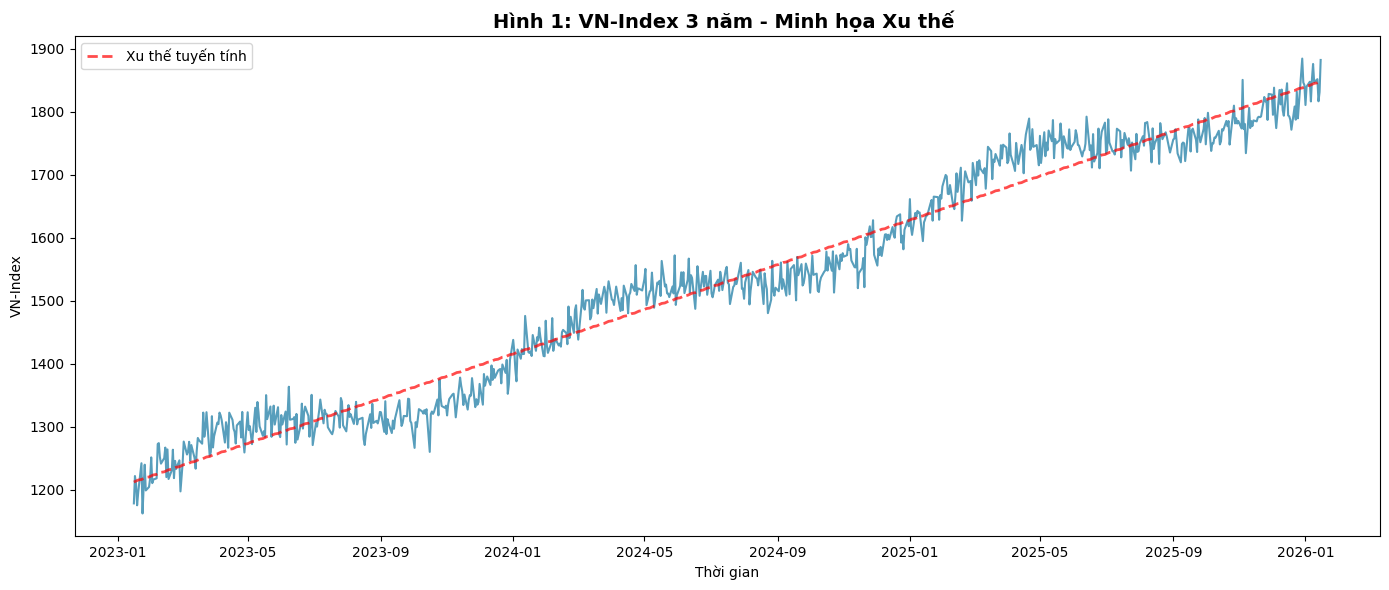

In [260]:
def create_vnindex_3years(target_end_price):
    """Tạo dữ liệu VN-Index mô phỏng trong 3 năm với xu thế, mùa vụ và nhiễu.

    Hàm này tạo ra một chuỗi dữ liệu VN-Index mô phỏng kéo dài 3 năm (từ 2023 đến 2026).
    Dữ liệu bao gồm 3 thành phần chính:
    1.  **Xu thế (Trend)**: Một đường thẳng tăng dần từ giá khởi điểm đến giá mục tiêu cuối kỳ.
    2.  **Tính mùa vụ (Seasonality)**: Biến động hình sin lặp lại, mô phỏng các chu kỳ lên xuống.
    3.  **Nhiễu (Noise)**: Các biến động ngẫu nhiên nhỏ, không thể dự đoán được.

    Args:
        target_end_price (float): Giá trị VN-Index mong muốn tại thời điểm cuối cùng của chuỗi mô phỏng
                                  (trong trường hợp này là ngày 15/01/2026). Giá này giúp định hình
                                  xu hướng tăng/giảm tổng thể của chuỗi.

    Returns:
        pd.DataFrame: Một DataFrame chứa hai cột:
                      - 'Date': Ngày giao dịch (bao gồm cả các ngày làm việc).
                      - 'VN-Index': Giá trị VN-Index mô phỏng tương ứng.
    """
    # Tạo các ngày giao dịch từ 15/01/2023 đến 15/01/2026 (freq='B' là Business Day - ngày làm việc)
    dates = pd.date_range('2023-01-15', '2026-01-15', freq='B')
    np.random.seed(123)  # Thiết lập 'hạt giống' (seed) cho các số ngẫu nhiên. Số '123' giúp
                         # đảm bảo rằng mỗi khi bạn chạy lại đoạn code này, phần 'nhiễu' sẽ giống hệt nhau,
                         # giúp kết quả mô phỏng có thể tái lập được.
    n = len(dates) # Tổng số ngày giao dịch trong 3 năm

    start_price = 1200  # Giá VN-Index khởi điểm được chọn là 1200 điểm cho chuỗi mô phỏng này.
                        # Đây là điểm bắt đầu của xu hướng dài hạn.
    trend = np.linspace(start_price, target_end_price, n) # Tạo một đường xu thế tuyến tính
                                                       # tăng đều từ 'start_price' đến 'target_end_price'
                                                       # qua 'n' bước.

    seasonality = 40 * np.sin(np.linspace(0, 6*np.pi, n)) # Thêm yếu tố mùa vụ. Số '40' đại diện cho biên độ
                                                      # của biến động mùa vụ (tức là giá trị VN-Index
                                                      # sẽ dao động lên/xuống khoảng 40 điểm so với xu thế).
                                                      # '6*np.pi' tạo ra 3 chu kỳ mùa vụ trong 3 năm (mỗi 2*pi là 1 chu kỳ).
    noise = np.random.normal(0, 20, n) # Thêm nhiễu ngẫu nhiên. '0' là giá trị trung bình của nhiễu,
                                     # còn '20' là độ lệch chuẩn, tức là hầu hết các nhiễu sẽ nằm trong khoảng
                                     # +/- 20 điểm so với giá trị thực. Nhiễu làm cho dữ liệu có tính 'ngẫu nhiên' hơn.
    values = trend + seasonality + noise # Kết hợp cả 3 thành phần để tạo ra chuỗi giá trị cuối cùng.

    return pd.DataFrame({'Date': dates, 'VN-Index': values})

df_3years = create_vnindex_3years(current_price)

plt.figure(figsize=(14, 6))
plt.plot(df_3years['Date'], df_3years['VN-Index'],
         linewidth=1.5, color='#2E86AB', alpha=0.8)

z = np.polyfit(range(len(df_3years)), df_3years['VN-Index'], 1)
p = np.poly1d(z)
plt.plot(df_3years['Date'], p(range(len(df_3years))),
         "--", linewidth=2, color='red', alpha=0.7, label='Xu thế tuyến tính')

plt.title(f'Hình 1: VN-Index 3 năm - Minh họa Xu thế ', fontsize=14, fontweight='bold')
plt.xlabel('Thời gian')
plt.ylabel('VN-Index')
plt.legend()
plt.tight_layout()
plt.show()

Dữ liệu chuỗi thời gian có thể có nhiều dạng tính xu thế khác nhau. Giả sử, xem xét một chuỗi $\left\{ y_{t} \right\}$ có xu thế:

- Xu thế tuyến tính theo thời gian:     $y_{t} = \beta_{0} + \beta_{1}t + u_{t},\ \ \ \ \ t = 1,\ 2,\ \ldots.,\ T$. Nếu $\beta_{1} > 0$, chuỗi $\left\{ y_{t} \right\}$ có xu hướng tăng. Nếu $\beta_{1} <0 $, chuỗi $\left\{ y_{t} \right\}$ có xu hướng giảm.


-   Xu thế thời gian bậc 2:     $y_{t} = \beta_{0} + \beta_{1}t + \beta_{2}t^{2} + u_{t},\ \ \ \ \ t = 1,\ 2,\ \ldots.,\ T$
Nếu $\beta_{1} > 0$ và $\beta_{2} >0 $, chuỗi $\left\{ y_{t} \right\}$ có xu hướng tăng và ngược lại. Nếu $\beta_{1} > 0$ và $\beta_{2} < 0 $, biểu diễu chuỗi $\left\{ y_{t} \right\}$ là một đường cong lồi, nghĩa là biến tăng nhưng sau đó giảm dần, và ngược lại.

-   Xu thế dạng mũ:     $log(y_{t}) = \beta_{0} + \beta_{1}t + u_{t},\ \ \ \ \ t = 1,\ 2,\ \ldots.,\ T$. Trong đó $\beta_{1}$ là tốc độ tăng trung bình mỗi kỳ của $y_{t}$


### **2.2. Tính chu kỳ/ Tính mùa vụ**

Tính chu kỳ là sự lặp lại đều đặn của cùng một đặc điểm trong thời gian dài (thường dài hơn một năm), không theo một khoảng thời gian nào cố định. Một chu kỳ thường đo thời gian giữa hai đỉnh hoặc đáy liên tiếp.
Tính mùa vụ là sự lặp lại đều đặn của cùng một đặc điểm trong vòng một năm (khoảng thời gian thường không dài hơn một năm). Tính mùa vụ có thể hiểu là tính chu kỳ nhưng kèm theo điều kiện là sự thay đổi phụ thuộc vào một lịch cố định nào đó trong năm. Khi đó biểu đồ đường của biến sẽ có dạng sóng đều đặn trong một khoảng thời gian ngắn. Khoảng thời gian trung bình giữa hai đỉnh hoặc đáy liên tiếp của biến có tính mùa vụ thường ngắn hơn biến có tính chu kỳ. Đồng thời, mức độ thay đổi của biến có tính mùa vụ cũng ít biến động hơn biến có tính chu kỳ. Hình 2. là biểu đồ đường minh họa tính mùa vụ và tính chu kỳ của dữ liệu chuỗi thời gian

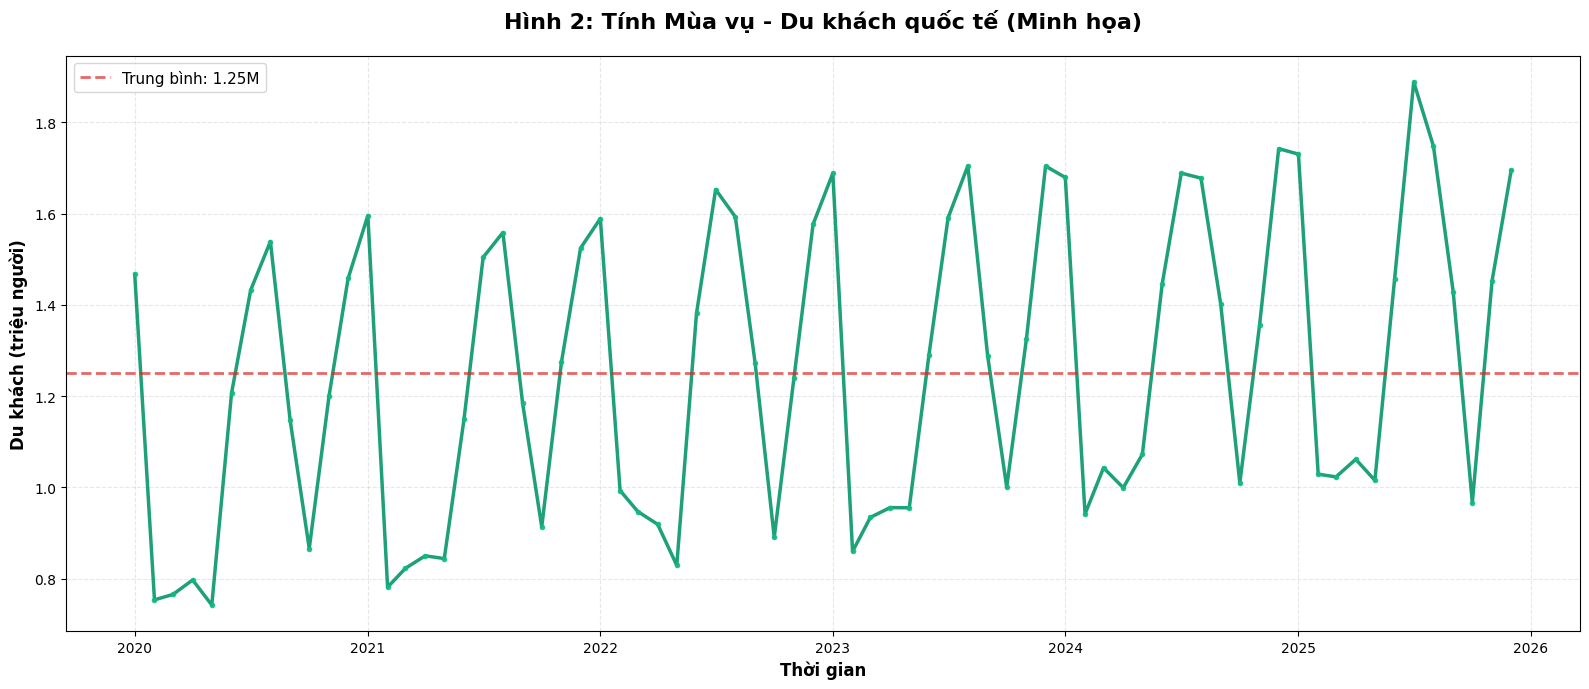

In [261]:
def create_seasonal_data():
    """Tạo dữ liệu du khách quốc tế mô phỏng với tính mùa vụ và xu hướng tăng trưởng.

    Hàm này tạo ra một chuỗi dữ liệu mô phỏng về số lượng du khách quốc tế hàng tháng
    từ tháng 01/2020 đến tháng 12/2025. Dữ liệu này được thiết kế để thể hiện rõ
    tính mùa vụ (số lượng du khách thay đổi theo tháng trong năm) và một xu hướng tăng trưởng
    nhẹ theo từng năm.

    Returns:
        pd.DataFrame: DataFrame chứa hai cột:
                      - 'Date': Ngày đầu tiên của mỗi tháng.
                      - 'Tourist_Arrivals': Số lượng du khách quốc tế mô phỏng.
    """
    # Tạo một chuỗi ngày từ tháng 01/2020 đến tháng 12/2025, với tần suất hàng tháng (MS = Month Start)
    months = pd.date_range('2020-01', '2025-12', freq='MS')
    seasonal_pattern = []

    for date in months:
        month = date.month
        # Các giá trị 'base' này đại diện cho số lượng du khách cơ bản trong một tháng cụ thể.
        # Chúng được phân chia theo mùa để mô phỏng tính mùa vụ trong du lịch.
        if month in [7, 8, 12, 1]: # Các tháng cao điểm du lịch (tháng 7, 8, 12, 1)
            base = 1500000 # Số lượng du khách cơ bản là 1,500,000 người.
        elif month in [6, 9, 11]: # Các tháng trung bình (tháng 6, 9, 11)
            base = 1200000 # Số lượng du khách cơ bản là 1,200,000 người.
        else: # Các tháng thấp điểm (các tháng còn lại)
            base = 800000  # Số lượng du khách cơ bản là 800,000 người.

        # Hệ số tăng trưởng hàng năm: Mô phỏng việc du lịch phát triển theo thời gian.
        # '50000' là số lượng du khách tăng thêm mỗi năm so với năm gốc 2020.
        # Ví dụ: năm 2021 sẽ tăng thêm 50,000; năm 2022 tăng 100,000, v.v.
        year_factor = (date.year - 2020) * 50000
        # Thêm nhiễu ngẫu nhiên để làm cho dữ liệu trông thực tế hơn. '0' là giá trị trung bình
        # của nhiễu, '50000' là độ lệch chuẩn. Điều này có nghĩa là số lượng du khách
        # thực tế có thể dao động xung quanh giá trị cơ bản +/- 50,000 người một cách ngẫu nhiên.
        noise = np.random.normal(0, 50000)
        # Đảm bảo số lượng du khách không âm bằng cách lấy giá trị lớn nhất giữa kết quả và 0.
        seasonal_pattern.append(max(base + year_factor + noise, 0))

    return pd.DataFrame({'Date': months, 'Tourist_Arrivals': seasonal_pattern})

df_seasonal = create_seasonal_data()

plt.figure(figsize=(16, 7))
plt.plot(df_seasonal['Date'], df_seasonal['Tourist_Arrivals']/1000000,
         linewidth=2.5, color='#059669', marker='o', markersize=4,
         markerfacecolor='#10b981', markeredgewidth=0, alpha=0.9)

# Thêm đường trung bình
mean_value = df_seasonal['Tourist_Arrivals'].mean()/1000000
plt.axhline(y=mean_value, color='#dc2626', linestyle='--',
            linewidth=2, alpha=0.7, label=f'Trung bình: {mean_value:.2f}M')

plt.title('Hình 2: Tính Mùa vụ - Du khách quốc tế (Minh họa)',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Thời gian', fontsize=12, fontweight='bold')
plt.ylabel('Du khách (triệu người)', fontsize=12, fontweight='bold')
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3, linestyle='--')

# Format trục x
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


### **2.3. Tính dừng và tầm quan trọng của tính dừng**

Một chuỗi thời gian dừng là việc phân phối xác suất của chuỗi không thay đổi qua thời gian. Phân phối xác suất của một chuỗi là không dừng nếu phân phối đó đảm bảo ba đặc tính sau:

  1. Giá trị trung bình không đổi qua thời gian:     $E\left( x_{t} \right) = \mu$

  2. Phương sai không đổi qua thời gian:
    $Var\left( x_{t} \right) = \sigma^{2}$
  3. Hiệp phương sai chỉ phụ thuộc vào khoảng cách giữa các thời điểm, chứ không phụ thuộc vào thời điểm cụ thể:     $Cov\left( x_{t},\ x_{t + h} \right) = \gamma_{h}$

Hình 3 là biểu đồ minh hoạ một chuỗi dừng và một chuỗi không dừng. Trong đó, có thể nhận thấy trong chuỗi không dừng, có xuất hiện xu hướng thời gian, đồng thời, giá trị trung bình và phương sai của chuỗi thay đổi phụ thuộc vào khoảng thời gian được lựa chọn để lấy mẫu dữ liệu. Một biến có tính xu thế thường không dừng, trong khi một biến có tính chu kỳ hoặc tính mùa vụ sẽ có tính dừng.

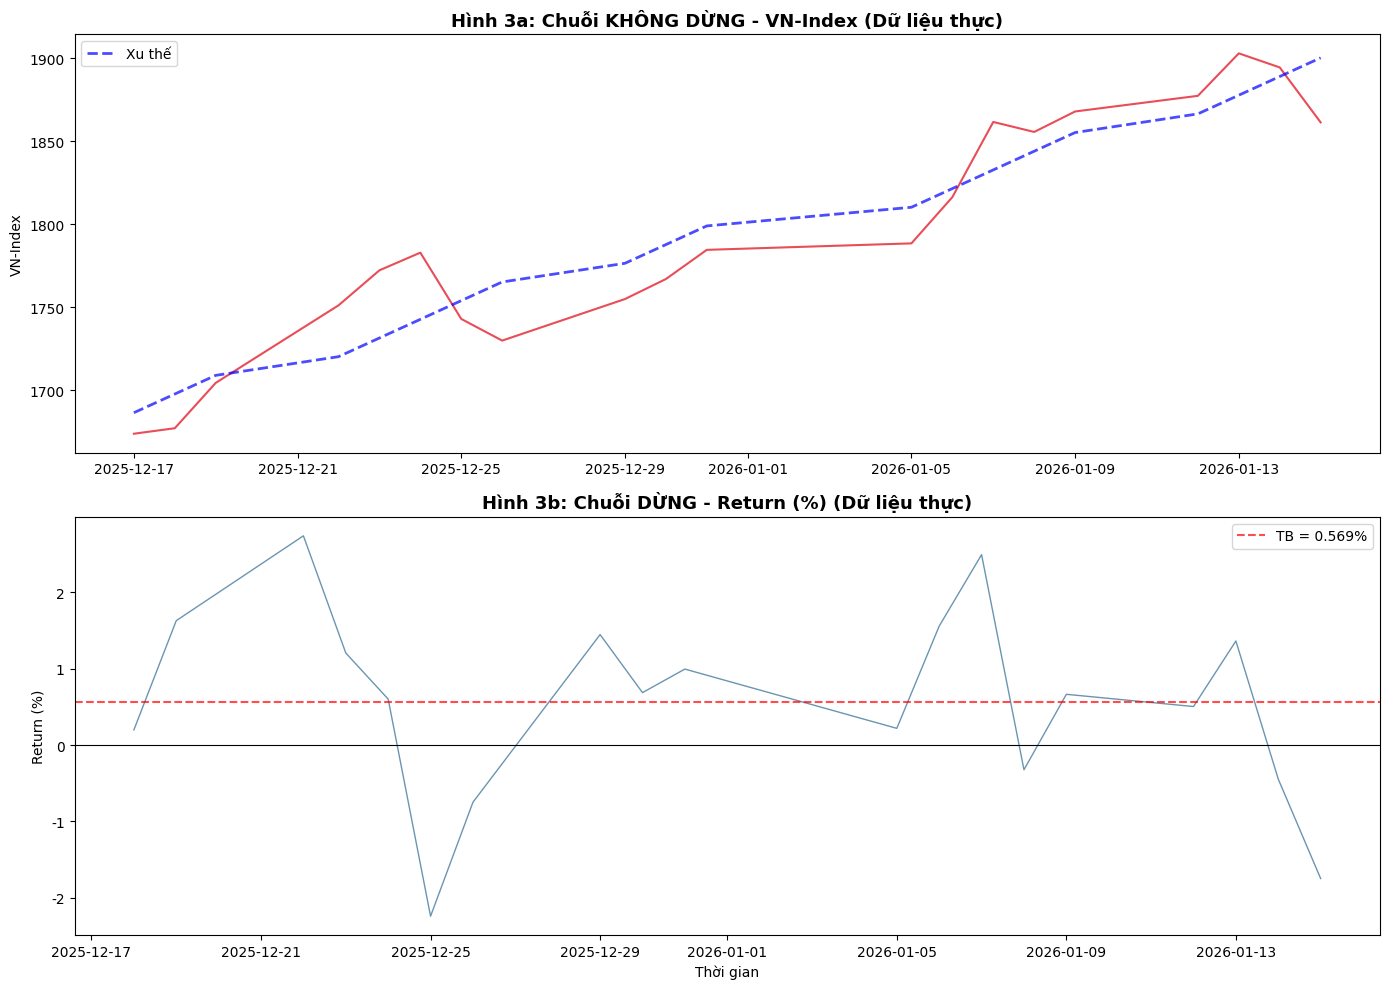

In [262]:
df_vnindex_real = df_vnindex.copy()
df_vnindex_real['Return'] = df_vnindex_real['VN-Index'].pct_change() * 100

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

ax1.plot(df_vnindex_real['Date'], df_vnindex_real['VN-Index'],
         linewidth=1.5, color='#E63946', alpha=0.9)
ax1.set_title('Hình 3a: Chuỗi KHÔNG DỪNG - VN-Index (Dữ liệu thực)', fontsize=13, fontweight='bold')
ax1.set_ylabel('VN-Index')

# Tính xu thế tuyến tính cho dữ liệu thực
z_real = np.polyfit(range(len(df_vnindex_real)), df_vnindex_real['VN-Index'], 1)
p_real = np.poly1d(z_real)
ax1.plot(df_vnindex_real['Date'], p_real(range(len(df_vnindex_real))),
         "--", linewidth=2, color='blue', alpha=0.7, label='Xu thế')

ax1.legend()

ax2.plot(df_vnindex_real['Date'], df_vnindex_real['Return'],
         linewidth=1, color='#457B9D', alpha=0.8)
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax2.axhline(y=df_vnindex_real['Return'].mean(), color='red',
           linestyle='--', linewidth=1.5, alpha=0.7,
           label=f'TB = {df_vnindex_real["Return"].mean():.3f}%')
ax2.set_title('Hình 3b: Chuỗi DỪNG - Return (%) (Dữ liệu thực)', fontsize=13, fontweight='bold')
ax2.set_xlabel('Thời gian')
ax2.set_ylabel('Return (%)')
ax2.legend()

plt.tight_layout()
plt.show()

Tính dừng (stationarity) của một chuỗi thời gian có ảnh hưởng rất lớn đến kết quả hồi quy trong các mô hình nghiên cứu định lượng, đặc biệt là trong phân tích dữ liệu chuỗi thời gian. Thứ nhất, việc hồi quy dữ liệu không dừng sẽ dẫn đến jết quả giả mạo (spurious regression). Trong trường hợp này, mô hình có thể tạo ra hệ số ước lượng và thống kê t có ý nghĩa, mặc dù giữa các biến không thực sự có mối quan hệ nhân quả. Điều này dẫn đến kết luận sai lầm về mối liên hệ giữa các biến. Giá trị R2 cũng có thể cao một cách giả tạo, làm người phân tích nghĩ rằng mô hình có sự phù hợp tốt với dữ liệu. Thứ hai, Khi các biến không dừng, các giả định về tính phân phối của sai số trong mô hình hồi quy có thể bị vi phạm. Điều này làm giảm hiệu lực của các kiểm định thống kê và ước lượng, dẫn đến kết quả không tin cậy. Thứ ba, trong trường hợp chuỗi không dừng, các ước lượng từ mô hình hồi quy tuyến tính có thể không hội tụ về giá trị thật khi kích thước mẫu tăng lên, làm cho các ước lượng không vững. Các hệ số ước lượng có thể bị chệch và phân phối của các hệ số này không tuân theo phân phối chuẩn, gây khó khăn cho việc áp dụng kiểm định giả thuyết và khoảng tin cậy.

### **3. Một số lưu ý khi phân tích dữ liệu chuỗi thời gian**

Đặc thù của dữ liệu chuỗi thời gian là khả năng xuất hiện của tính xu thế/ mùa vụ/ chu kỳ hoặc hiện tượng tự tương quan là rất lớn. Các đặc điểm này có thể dẫn đến hiện tượng chuỗi không dừng, gây ra những ảnh hưởng tiêu cực đến kết quả phân tích hồi quy. Biến đổi dữ liệu thô trong phân tích dữ liệu chuỗi thời gian là một bước quan trọng để đảm bảo tính chính xác và hiệu quả của các phương pháp phân tích. Cụ thể, việc biến đổi dữ liệu thô sẽ giúp loại bỏ xu hướng và tính mùa vụ, đảm bảo tính dừng, giảm biến thiên và sự mất cân đối, từ đó làm cho dữ liệu trở nên phù hợp với các giả định của các mô hình phân tích cũng như cải thiện khả năng dự đoán. Ba phương pháp biến đổi dữ liệu chuỗi thời gian phổ biến là lấy sai phân, logarit hoá, tính tốc độ tăng trưởng và chuẩn hoá dữ liệu.





### **3.1 SAI PHÂN (Differencing)**

- Lấy sai phân: Phương pháp lấy sai phân là trừ giá trị hiện tại của chuỗi thời gian cho giá trị của chuỗi ở thời điểm trước đó. Có thể thực hiện sai phân bậc 1, 2 hoặc cao hơn tùy thuộc vào mức độ loại bỏ xu hướng. Việc lấy sai phân sẽ giúp loại bỏ xu hướng trong dữ liệu và làm cho chuỗi thời gian trở nên dừng.

Công thức: $Δx_t = x_t - x_{t-k}$

In [263]:
print("""
# Sai phân bậc 1
df['diff_1'] = df['x_t'].diff(periods=1)

# Sai phân bậc 2
df['diff_2'] = df['diff_1'].diff(periods=1)
""")



# Sai phân bậc 1
df['diff_1'] = df['x_t'].diff(periods=1)

# Sai phân bậc 2
df['diff_2'] = df['diff_1'].diff(periods=1)



- Logarit hóa: Áp dụng hàm log lên các giá trị của chuỗi thời gian. Phương pháp này thường được sử dụng để biến đổi dữ liệu có phân phối không đều hoặc có sự khác biệt lớn về tỷ lệ tăng trưởng. Việc logarit hoá giúp giảm độ lớn của sự biến thiên và làm giảm ảnh hưởng của các điểm dữ liệu có giá trị lớn. Ký hiệu

### **3.2 LOGARIT HÓA**
- Logarit hóa: Áp dụng hàm log lên các giá trị của chuỗi thời gian. Phương pháp này thường được sử dụng để biến đổi dữ liệu có phân phối không đều hoặc có sự khác biệt lớn về tỷ lệ tăng trưởng. Việc logarit hoá giúp giảm độ lớn của sự biến thiên và làm giảm ảnh hưởng của các điểm dữ liệu có giá trị lớn. Ký hiệu

Công thức: $ln(x_t)$

In [264]:
print("""
import numpy as np

# Logarit tự nhiên
df['log_x'] = np.log(df['x_t'])

# Log cơ số 10
df['log10_x'] = np.log10(df['x_t'])
""")


import numpy as np

# Logarit tự nhiên
df['log_x'] = np.log(df['x_t'])

# Log cơ số 10
df['log10_x'] = np.log10(df['x_t'])



### **3.3 TỐC ĐỘ TĂNG TRƯỞNG**

●Tính tốc độ tăng trưởng: Tốc độ tăng trưởng có thể tính toán là tỷ lệ phần trăm thay đổi giữa giá trị hiện tại và giá trị trước đó. Tốc độ tăng trưởng cũng có thể được tính toán bằng hiệu giữa logirithm của hai quan sát. Việc sử dụng tốc độ tăng trưởng nhằm loại bỏ xu hướng tuyệt đối và nhấn mạnh sự thay đổi tương đối

Công thức: $\frac{x_{t} - x_{t - k}}{x_{t - k}} \approx ln\ \left( \frac{x_{t}}{x_{t - k}} \right)\  = ln\left( x_{t} \right) - ln\ \left( x_{t - k} \right)\  = \mathrm{\Delta}ln\left( x_{t} \right)$



In [265]:
print("""
# Cách 1: pct_change() - đơn giản nhất
df['growth_rate'] = df['x_t'].pct_change()

# Cách 2: Log return
df['log_return'] = np.log(df['x_t']).diff()

# Chuyển sang %
df['growth_rate_pct'] = df['growth_rate'] * 100
""")



# Cách 1: pct_change() - đơn giản nhất
df['growth_rate'] = df['x_t'].pct_change()

# Cách 2: Log return
df['log_return'] = np.log(df['x_t']).diff()

# Chuyển sang %
df['growth_rate_pct'] = df['growth_rate'] * 100



### **3.4 CHUẨN HÓA**

- Chuẩn hoá dữ liệu: Chuẩn hóa giá trị của chuỗi về khoảng [0,1] hoặc [-1,1] thông qua các phép biến đổi tuyến tính như Z-score hoặc min-max scaling.Chuẩn hoá dữ liệu giúp điều chỉnh giá trị của chuỗi thời gian về cùng một thang đo, đặc biệt khi các chuỗi có đơn vị đo lường khác nhau.

- Tóm lại, để phân tích chuỗi thời gian hiệu quả trong bối cảnh AI/ML, điều quan trọng không chỉ là chọn thuật toán “mạnh”, mà là xử lý đúng bản chất dữ liệu: nhận diện xu thế, mùa vụ, tính dừng. Một số thao tác đơn giản xử lý dữ liệu trước có thể giúp mô hình học được động học của chuỗi. Trên nền tảng đó, việc lựa chọn mô hình cần bám sát mục tiêu và cấu trúc dữ liệu đi kèm walk-forward validation/backtesting và cơ chế giám sát để duy trì hiệu năng trong vận hành. Nói cách khác, hiểu đúng đặc điểm chuỗi thời gian là điều kiện tiên quyết để AI/ML tạo ra kết quả đáng tin cậy và có giá trị sử dụng.

- Công thức:
  - $Z-score: (x - mean) / std$
  - $Min-Max: (x - min) / (max - min)$



In [266]:
print("""
# Z-score (mean=0, std=1)
df['zscore'] = (df['x_t'] - df['x_t'].mean()) / df['x_t'].std()

# Min-Max [0, 1]
df['minmax'] = (df['x_t'] - df['x_t'].min()) / (df['x_t'].max() - df['x_t'].min())

# Min-Max [-1, 1]
df['minmax_neg'] = 2 * df['minmax'] - 1
""")



# Z-score (mean=0, std=1)
df['zscore'] = (df['x_t'] - df['x_t'].mean()) / df['x_t'].std()

# Min-Max [0, 1]
df['minmax'] = (df['x_t'] - df['x_t'].min()) / (df['x_t'].max() - df['x_t'].min())

# Min-Max [-1, 1]
df['minmax_neg'] = 2 * df['minmax'] - 1

